In [1]:
from scipy.stats import multivariate_normal
from massart import addNoise, ground_truth_permutations, flip_ranking
from LabelRankers import *
import pickle

In [2]:
d = 10  # data dimension
k = 8  # labels

# Feature vectors distribution
D = multivariate_normal(mean=np.zeros(d), cov=np.identity(d))

# Linear Sorting Function
W = np.random.rand(k, d)

# Train data
X_train = D.rvs(size=5000)

R_train = ground_truth_permutations(X_train, W)
P_train = np.argsort(R_train, axis=1)

##### Train models using data with RCN

In [3]:
variances = np.arange(0.1, 1.05, .05)

LR_DT_R = {} # Decision Tree Regression
LR_DT_C = {} # Decision Tree Classification
LR_RF_R = {} # Random Forest Regression
LR_RF_C = {} # Random Forest Classification
LR_HH_C = {} # Homogeneous Halfspace Classification

for variance in variances:
  noise_dist = multivariate_normal(mean=np.zeros(k), cov=variance*np.identity(k))
  R_train_noisy = np.array([np.argsort(np.matmul(W, x) + noise_dist.rvs())[::-1] for x in X_train])
  P_train_noisy = np.argsort(R_train_noisy, axis=1)
  LR_DT_R[variance] = LabelwiseDecisionTreeLR().fit(X_train, P_train_noisy)
  LR_DT_C[variance] = PairwiseDecisionTreeLR().fit(X_train, P_train_noisy)
  LR_RF_R[variance] = LabelwiseRandomForestLR().fit(X_train, P_train_noisy)
  LR_RF_C[variance] = PairwiseRandomForestLR().fit(X_train, P_train_noisy)
  LR_HH_C[variance] = PairwiseHalfspaceLR(0.005, 0.1, 0.8).fit(X_train, P_train_noisy)

##### Save trained models and ground truth LSF

In [4]:
with open('trained models/Additive/LR_DT_R.pickle', 'wb') as handle: pickle.dump(LR_DT_R, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/Additive/LR_DT_C.pickle', 'wb') as handle: pickle.dump(LR_DT_C, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/Additive/LR_RF_R.pickle', 'wb') as handle: pickle.dump(LR_RF_R, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/Additive/LR_RF_C.pickle', 'wb') as handle: pickle.dump(LR_RF_C, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('trained models/Additive/LR_HH_C.pickle', 'wb') as handle: pickle.dump(LR_HH_C, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('trained models/Additive/W.pickle', 'wb') as handle: pickle.dump(W, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Load trained models and ground truth LSF

In [5]:
with open('trained models/Additive/LR_DT_R.pickle', 'rb') as handle: LR_DT_R = pickle.load(handle)
with open('trained models/Additive/LR_DT_C.pickle', 'rb') as handle: LR_DT_C = pickle.load(handle)
with open('trained models/Additive/LR_RF_R.pickle', 'rb') as handle: LR_RF_R = pickle.load(handle)
with open('trained models/Additive/LR_RF_C.pickle', 'rb') as handle: LR_RF_C = pickle.load(handle)
with open('trained models/Additive/LR_HH_C.pickle', 'rb') as handle: LR_HH_C = pickle.load(handle)

with open('trained models/Additive/W.pickle', 'rb') as handle: W = pickle.load(handle)

etas = np.array(list(LR_DT_R.keys()))

##### Create test data

In [6]:
X_test = D.rvs(size=1000)
R_test = ground_truth_permutations(X_test, W)
P_test = np.argsort(R_test, axis=1)

##### Predict rankings for all classifiers and etas

In [7]:
LR_DT_R_preds = {variance: LR_DT_R[variance].predict(X_test) for variance in variances}
LR_DT_C_preds = {variance: LR_DT_C[variance].predict(X_test) for variance in variances}
LR_RF_R_preds = {variance: LR_RF_R[variance].predict(X_test) for variance in variances}
LR_RF_C_preds = {variance: LR_RF_C[variance].predict(X_test) for variance in variances}
LR_HH_C_preds = {variance: LR_HH_C[variance].predict(X_test) for variance in variances}

##### Find scores for all classifiers and etas

In [8]:
LR_DT_R_KT_corr = {variance: mean_kendall_rank_corr(P_test, LR_DT_R_preds[variance]) for variance in variances}
LR_DT_C_KT_corr = {variance: mean_kendall_rank_corr(P_test, LR_DT_C_preds[variance]) for variance in variances}
LR_RF_R_KT_corr = {variance: mean_kendall_rank_corr(P_test, LR_RF_R_preds[variance]) for variance in variances}
LR_RF_C_KT_corr = {variance: mean_kendall_rank_corr(P_test, LR_RF_C_preds[variance]) for variance in variances}
LR_HH_C_KT_corr = {variance: mean_kendall_rank_corr(P_test, LR_HH_C_preds[variance]) for variance in variances}

LR_DT_R_KT_dist = {variance: mean_kendall_rank_dist(P_test, LR_DT_R_preds[variance]) for variance in variances}
LR_DT_C_KT_dist = {variance: mean_kendall_rank_dist(P_test, LR_DT_C_preds[variance]) for variance in variances}
LR_RF_R_KT_dist = {variance: mean_kendall_rank_dist(P_test, LR_RF_R_preds[variance]) for variance in variances}
LR_RF_C_KT_dist = {variance: mean_kendall_rank_dist(P_test, LR_RF_C_preds[variance]) for variance in variances}
LR_HH_C_KT_dist = {variance: mean_kendall_rank_dist(P_test, LR_HH_C_preds[variance]) for variance in variances}

##### Plot scores for all classifiers and etas

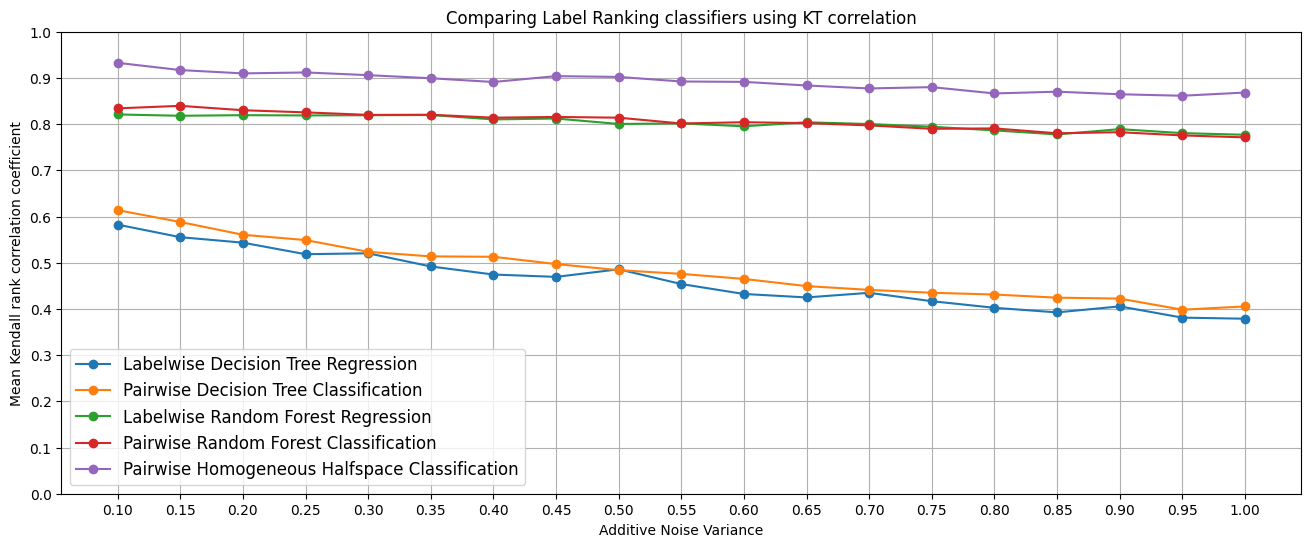

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.title('Comparing Label Ranking classifiers using KT correlation')
plt.plot(variances, LR_DT_R_KT_corr.values(), '-o')
plt.plot(variances, LR_DT_C_KT_corr.values(), '-o')
plt.plot(variances, LR_RF_R_KT_corr.values(), '-o')
plt.plot(variances, LR_RF_C_KT_corr.values(), '-o')
plt.plot(variances, LR_HH_C_KT_corr.values(), '-o')
plt.legend([
  'Labelwise Decision Tree Regression',
  'Pairwise Decision Tree Classification',
  'Labelwise Random Forest Regression',
  'Pairwise Random Forest Classification',
  'Pairwise Homogeneous Halfspace Classification'
  ], 
  fontsize=12
)
plt.xticks(variances)
plt.yticks(0.1*np.arange(11))
plt.xlabel('Additive Noise Variance')
plt.ylabel('Mean Kendall rank correlation coefficient')
plt.grid()
plt.show()

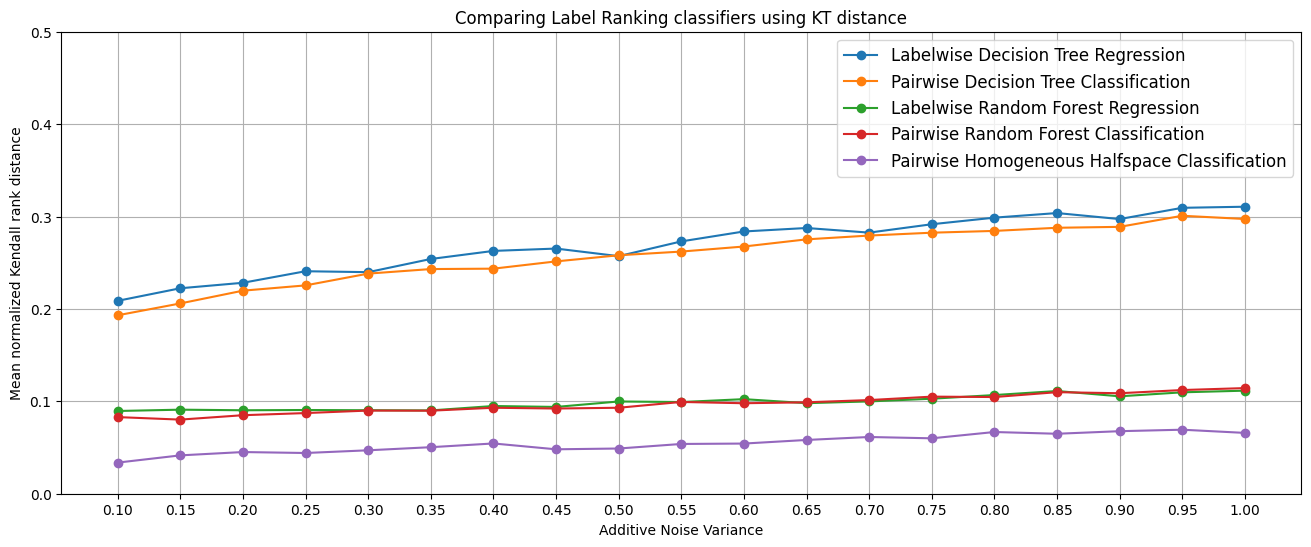

In [12]:
plt.figure(figsize=(16, 6))
plt.title('Comparing Label Ranking classifiers using KT distance')
plt.plot(variances, LR_DT_R_KT_dist.values(), '-o')
plt.plot(variances, LR_DT_C_KT_dist.values(), '-o')
plt.plot(variances, LR_RF_R_KT_dist.values(), '-o')
plt.plot(variances, LR_RF_C_KT_dist.values(), '-o')
plt.plot(variances, LR_HH_C_KT_dist.values(), '-o')
plt.legend([
  'Labelwise Decision Tree Regression',
  'Pairwise Decision Tree Classification',
  'Labelwise Random Forest Regression',
  'Pairwise Random Forest Classification',
  'Pairwise Homogeneous Halfspace Classification'
  ], 
  fontsize=12
)
plt.xticks(etas)
plt.yticks(0.1*np.arange(6))
plt.xlabel('Additive Noise Variance')
plt.ylabel('Mean normalized Kendall rank distance')
plt.grid()
plt.show()